# Installing Abra Package

Run the command: 

**pip install abra**

In order to install the package to your local environment.

# Import Abra

In [1]:
import numpy as np
import abra
import abra.data as abra

# Read in Data

- 'read' function can read in .asc file converted from edf files
- 'mode' parament has two modes: default ('d') and user define ('u'). Default mode means that the experiment code uses the tracker record and stop function for trial separation. For user define mode, you need to use regular expression in 'start_msg' and 'end_msg' to extract the starting and ending marker of each trial.

In [2]:
abra_data = abra.read('data.asc', mode = 'd')

# Available data properties

- timestamps: timestamps for each data point (might be duplicated depending on the sampling rate)
- pupil_size: the pupil size data
- movement: the eye movement data
- sample_rate: the sampling rate of the data
- messages: a dictionary of the 'MSG' lines in the data file, indexed by timestamps
- events: the eye tracker define events (eg. 'EBLINK R')
- trial_markers: the timestamps for the starting and ending of each trial (extracted from the read function)

In [3]:
# Below are the data in arrays of the timestamps and the pupilsize

print(abra_data.timestamps)
print(abra_data.pupil_size)

[ 933437  933437  933438 ... 1685063 1685064 1685064]
[879.6 878.5 877.6 ... 967.6 966.1 968.7]


# Exploratory Data Analysis

- The following data looks at pupillometry from an experiment measuring intention

- It is important to mention this would be a good time to use the trial viewer GUI application under 'trial_inspect.py' to   determine your data's good and bad trials

In [4]:
# Clean the eyeblinks using linear interpolation
new_data = abra.remove_eye_blinks(abra_data, buffer=50, interpolate= 'linear', inplace=False)

In [5]:
# Looking at pupil size, movement, trial markers

print("Pupil Size", new_data.pupil_size)
print("Trial Markers", new_data.trial_markers)
print("X Movement", new_data.movement[0])
print("Y Movement", new_data.movement[1])

Pupil Size [879.6 878.5 877.6 ... 967.6 966.1 968.7]
Trial Markers {'start': [933437, 958574, 972910, 988665, 1009507, 1032229, 1047971, 1061996, 1090961, 1109287, 1131097, 1151346, 1173355, 1187276, 1201652, 1226815, 1242324, 1266624, 1281592, 1296880, 1321753, 1345908, 1367585, 1388902, 1409278, 1426225, 1443649, 1457881, 1473603, 1493572, 1507405, 1523077, 1540455, 1552870, 1577372, 1596290, 1610619, 1634514, 1653980, 1673397], 'end': [955550, 970317, 986457, 1006414, 1029792, 1045585, 1060006, 1084297, 1107182, 1129286, 1148528, 1171104, 1185362, 1199621, 1224269, 1236448, 1264645, 1278700, 1295141, 1319205, 1341391, 1365548, 1387485, 1406652, 1424708, 1441847, 1455297, 1471762, 1491347, 1505558, 1521142, 1534504, 1550499, 1575363, 1594756, 1607840, 1633041, 1652594, 1671490, 1685065]}
X Movement [1411. 1411. 1412. ...  606.  606.  606.]
Y Movement [480.1 480.5 481.9 ... 553.9 553.7 551.7]


In [6]:
# Creating Sessions and looking at the summary statistics 
session_data = new_data.create_session()
print(session_data.summary())

{'mean': 977.6422331977976, 'variance': 3038.1627065152784, 'stdev': 55.11953108032831, 'length': 1305930, 'min': -606.5, 'max': 1707.7}


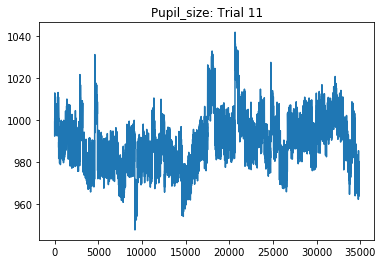

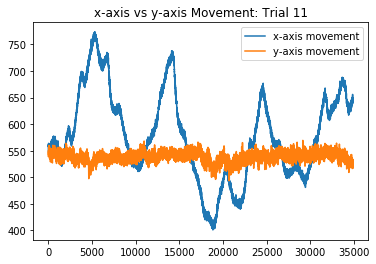

C:\Users\Nathanael\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Nathanael\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


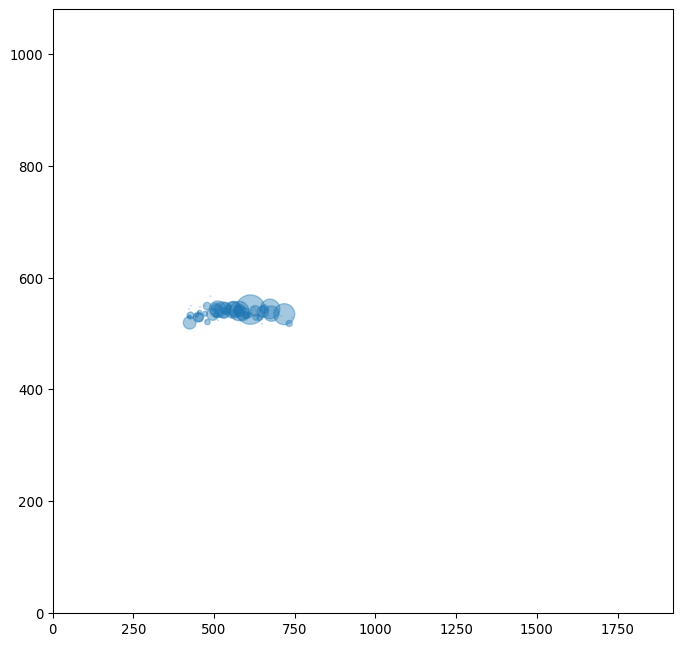

In [7]:
# Visualizing pupil size and movement

# Pupil Size
pupil_data = session_data.get_pupil()

# Movement 
fix_data = session_data.get_fixation()
xy_data = session_data.get_movement()


# Visualization

session_data.plot_pupil_size(11)
session_data.plot_xy(11)
session_data.get_bubble_plot(11)

# Time-Locking Analysis

- Many analyses require the use of subsetting to a specific stimulus or time during the experiment. The epoch functionality is useful when this case is needed.

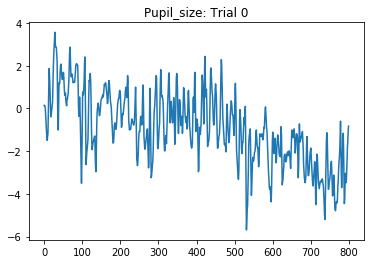

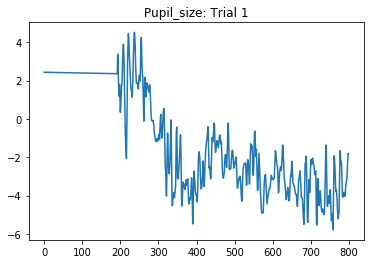

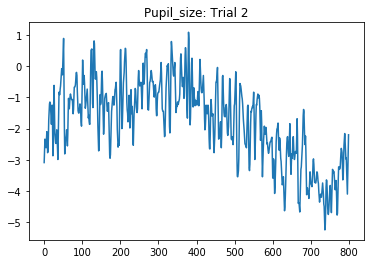

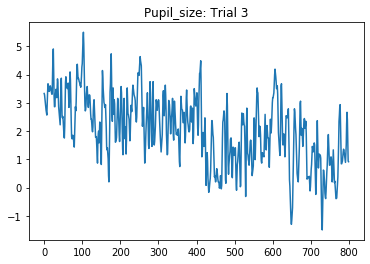

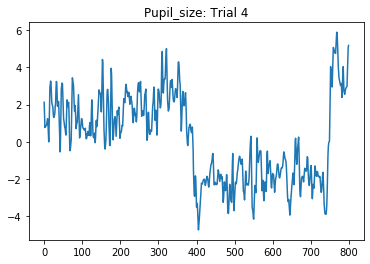

In [8]:
# Epoching for time-locking analysis
event_timestamps = np.array(new_data.trial_markers['start']) + 1000
epoch_data = new_data.create_epochs(event_timestamps, conditions= None, pre_event= 200, post_event=200, pupil_baseline=[-200,-100])

# Looking at the first 5 trials for analysis
trials_initial = epoch_data.data[0:5]
for trial in range(len(trials_initial)):
    epoch_data.plot_pupil_size(trial)

## You should now have all of the data and tools you need to do any further analysis with Python and your pupillometry data.